In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, block_diag
from scipy.sparse.linalg import spsolve
from tqdm import tqdm

def set_Laplacian2D(nx, mesh_size):
    # central differece
    diagonals = [np.ones(nx), -2*np.ones(nx), np.ones(nx)]
    offsets = [-1, 0, 1]
    L = diags(diagonals, offsets, shape=(nx, nx), format='csr')
    I = diags(np.ones(nx), shape=(nx, nx))
    L[0,-1] = L[-1,0] = 1
    
    L = kron(L, I) + kron(I, L)
    return L / mesh_size**2

def set_nuemann2D(Nx, h):
    # bulid the block
    diag_cor = 3*np.ones(Nx)
    diag_cor[0] = diag_cor[-1] = 2

    diag_cen = 4*np.ones(Nx)
    diag_cen[0] = diag_cen[-1] = 3

    off_I = diags([np.ones(Nx**2), np.ones(Nx**2)], \
                  [Nx,-Nx], shape=(Nx**2, Nx**2))

    corB = diags([np.ones(Nx), -diag_cor, np.ones(Nx)], \
                 [-1, 0, 1], shape=(Nx, Nx))

    cenB = diags([np.ones(Nx), -diag_cen, np.ones(Nx)], \
                 [-1, 0, 1], shape=(Nx, Nx))

    diagBs = [cenB for i in range(Nx-2)]
    diagBs = tuple([corB]+diagBs+[corB])

    L = block_diag(diagBs) + off_I
    return L / h**2

def set_boundary(u):
    # set top, botton, left, right
    u[0, 1:-1] = u[1, 1:-1]
    u[-1, 1:-1] = u[-2, 1:-1]
    u[1:-1, 0] = u[1:-1, 1]
    u[1:-1, -1] = u[1:-1 ,-2]

    # set the corner
    u[0, 0] = u[1, 1]
    u[-1, -1] = u[-2, -2]
    u[-1, 0] = u[-2, 1]
    u[0, -1] = u[1, -2]
    return u

# def set_boundary(u, a, h):
#     # set top, botton, left, right
#     u[0, 1:-1] = u[1, 1:-1] - 2*a*h
#     u[-1, 1:-1] = u[-2, 1:-1] + 2*a*h
#     u[1:-1, 0] = u[1:-1, 1] + 2*a*h
#     u[1:-1, -1] = u[1:-1 ,-2] - 2*a*h

#     # set the corner
#     u[0, 0] = u[1, 1]
#     u[-1, -1] = u[-2, -2]
#     u[-1, 0] = u[-2, 1]
#     u[0, -1] = u[1, -2]
#     return u


def set_meshgrid(x, y):
    X, Y = np.meshgrid(x, y)
    return X, Y

In [13]:
L = set_nuemann2D(4, 1).toarray()

eig, eigvec = np.linalg.eig(-L)

print(max(eig))

6.828427124746195


In [178]:
eps = 0.1
L = 10
Nx = Ny = 2**3
x = np.linspace(-L/2, L/2, Nx)
y = np.linspace(-L/2, L/2, Ny)
# x = x[:-1]
# y = y[:-1]
# u = np.cos(x)

X, Y = set_meshgrid(x, y)
u = np.cos(X + Y)
# u = np.random.rand(Nx-1, Ny-1)
# u = np.tanh(1-((X)**2+(Y)**2))*0.4
u = u.flatten()

# 計算網格間距
dx = L / (Nx - 1)
dt = 1e-2
iter_max = 10**3

Lap = set_Laplacian2D(Nx-1, dx)
I = diags(np.ones((Nx-1)**2), shape=((Nx-1)**2, (Nx-1)**2))

H = I - dt*eps*Lap

u_historyArray = u

for i in range(iter_max):
    u = spsolve(H, u)
    u_historyArray = np.vstack([u_historyArray, u])


ValueError: matrix - rhs dimension mismatch ((49, 49) - 64)

In [14]:
L = 10
Nx = Ny = 2**3
x = np.linspace(-L/2, L/2, Nx)
y = np.linspace(-L/2, L/2, Ny)
# x = x[:-1]
# y = y[:-1]
# u = np.cos(x)

X, Y = set_meshgrid(x, y)
# u = np.cos(X + Y)
# u = np.random.rand(Nx-1, Ny-1)
u = np.tanh(1-((X)**2+(Y)**2))*0.4

In [4]:
eps = 0.1
L = 10
Nx = Ny = 2**7
x = np.linspace(-L/2, L/2, Nx)
y = np.linspace(-L/2, L/2, Ny)
# x = x[:-1]
# y = y[:-1]
# u = np.cos(x)

X, Y = set_meshgrid(x, y)
u0 = np.cos(X + Y)
# u0 = np.random.rand(Nx, Ny)
# u0 = np.tanh(1-((X)**2+(Y)**2))*0.4


# 計算網格間距
dx = L / (Nx - 1)
dt = 1e-1
iter_max = 10**2
a = 0

Lap = set_nuemann2D(Nx-2, dx)
I = diags(np.ones((Nx-2)**2), shape=((Nx-2)**2, (Nx-2)**2))

H = I - dt*eps*Lap

u_historyArray = [u0]

for i in range(iter_max):
    U = u_historyArray[-1].copy()
    u_interior = U[1:-1,1:-1].flatten()
    u_interior = spsolve(H, u_interior)

    
    u_interior = u_interior.reshape(Nx-2, Nx-2)
    U[1:-1, 1:-1] = u_interior
    U = set_boundary(U)
    
#     U[0, 1:-1] = u_interior[0, 0:]
#     U[-1, 1:-1] = u_interior[-1, 0:]
#     U[1:-1, 0] = u_interior[0:, 0]
#     U[1:-1, -1] = u_interior[0: ,-1]

    
#     U[0, 0] = u_interior[0, 0]
#     U[-1, -1] = u_interior[-1, -1]
#     U[-1, 0] = u_interior[-1, 0]
#     U[0, -1] = u_interior[0, -1]

    u_historyArray.append(U)

In [11]:
a = np.array(u_historyArray)

In [5]:
print(u_historyArray[0])
print('\n')
print(u_historyArray[-1])

[[-0.83907153 -0.8792638  -0.91400745 ...  0.98762558  0.9969016
   1.        ]
 [-0.8792638  -0.91400745 -0.94308716 ...  0.9969016   1.
   0.9969016 ]
 [-0.91400745 -0.94308716 -0.96632274 ...  1.          0.9969016
   0.98762558]
 ...
 [ 0.98762558  0.9969016   1.         ... -0.96632274 -0.94308716
  -0.91400745]
 [ 0.9969016   1.          0.9969016  ... -0.94308716 -0.91400745
  -0.8792638 ]
 [ 1.          0.9969016   0.98762558 ... -0.91400745 -0.8792638
  -0.83907153]]


[[-0.01194703 -0.01194703 -0.01062371 ...  0.50415593  0.50515938
   0.50515938]
 [-0.01194703 -0.01194703 -0.01062371 ...  0.50415593  0.50515938
   0.50515938]
 [-0.01062371 -0.01062371 -0.00930549 ...  0.50315786  0.50415593
   0.50415593]
 ...
 [ 0.50415593  0.50415593  0.50315786 ... -0.00930549 -0.01062371
  -0.01062371]
 [ 0.50515938  0.50515938  0.50415593 ... -0.01062371 -0.01194703
  -0.01194703]
 [ 0.50515938  0.50515938  0.50415593 ... -0.01062371 -0.01194703
  -0.01194703]]


In [6]:
np.diff(a, axis=0)

ValueError: diff requires input that is at least one dimensional

In [41]:
mass_list = [np.sum(a) for a in np.diff(np.array(u_historyArray), axis=0)]

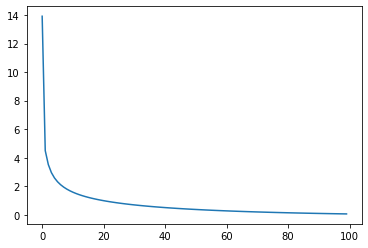

In [42]:
plt.plot(mass_list)

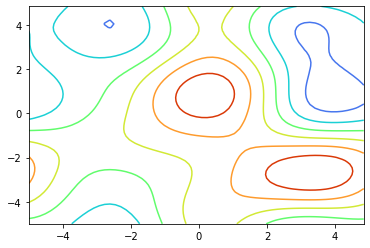

In [25]:
Z = np.reshape(u_historyArray[-1], (Nx-1,Ny-1))
plt.contour(X,Y,Z, cmap=plt.get_cmap('turbo'))
plt.show()

In [108]:
arr = np.array([
    [[1, 2, 3],
     [4, 5, 6]],
    
    [[7, 8, 9],
     [10, 11, 12]],
    
    [[13, 14, 15],
     [16, 17, 18]]
])

# 获取第一个2D数组
first_2d_array = arr[1]

print(first_2d_array)

[[ 7  8  9]
 [10 11 12]]


(-1e-13, 1e-13)

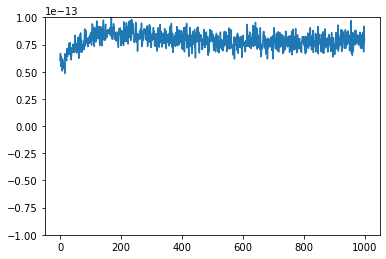

In [22]:
plt.plot(mass_list)
plt.ylim(-1e-13,1e-13)

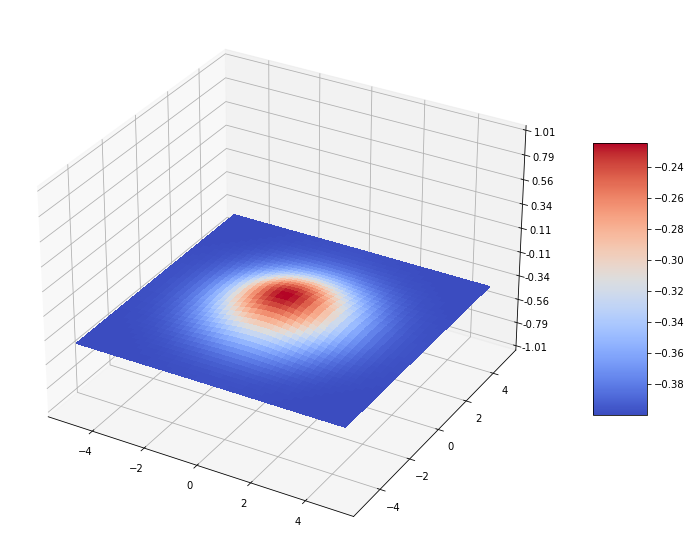

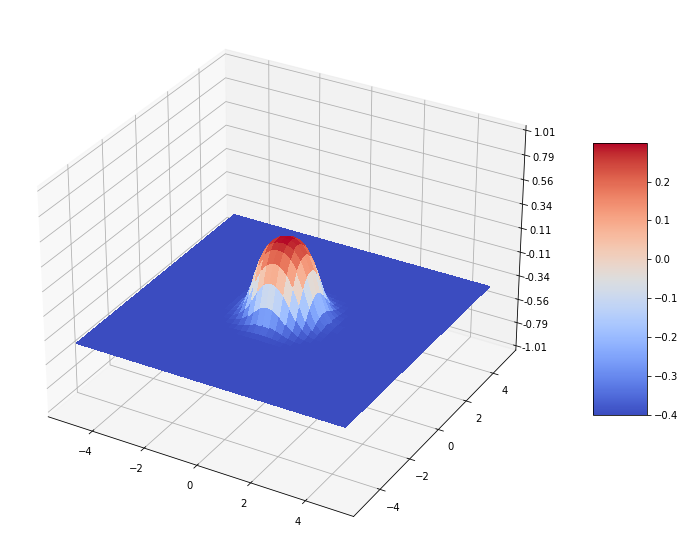

In [184]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator


# Z = np.tanh(1-((X)**2+(Y)**2))*0.4
Z = np.reshape(u_historyArray[-1], (Nx,Ny))

fig, ax = plt.subplots(figsize=(15,10),subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()






Z = np.reshape(u_historyArray[0], (Nx,Ny))

fig, ax = plt.subplots(figsize=(15,10),subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [14]:
Z = u_historyArray[-1].reshape((Nx-1, Ny-1))

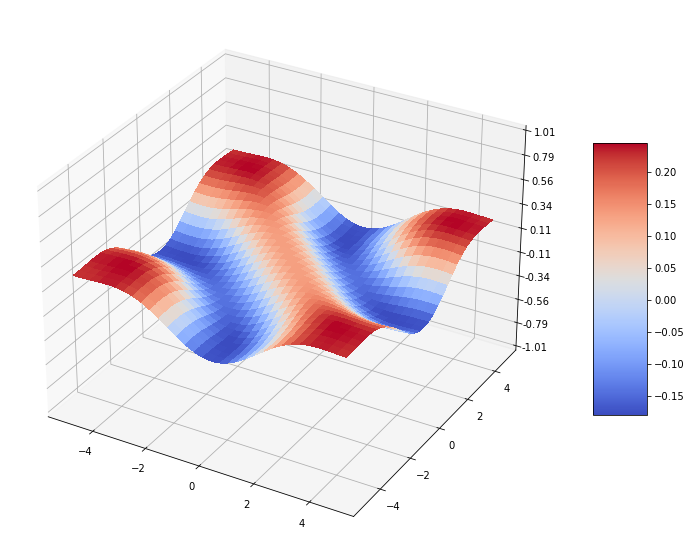

In [15]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(figsize=(15,10),subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [18]:
import json

data_info = {
    "width" : eps,
#     "iteration count": itr_count,
    "spatial domain" : [-L/2, L/2],
    "number of points in time": dt,
    "number of points in space": [Nx, Ny],
    "inital value": u_historyArray[0].tolist(),
    "boundary condition": "periodic",
    "mass": u_historyArray.tolist()
}

with open(f"data/classical_diffusion2D.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(data_info, f)

In [4]:
np.savetxt("test_txt", u_historyArray)

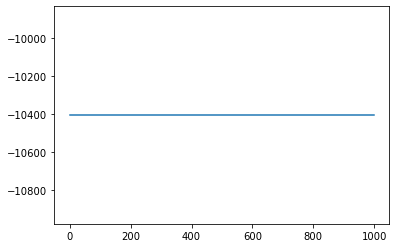

In [39]:
plt.plot(mass)

In [17]:
u 

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])